# Model evaluation

## General Data Wrangling

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, FunctionTransformer, PowerTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
import altair as alt
alt.renderers.enable('mimetype')
alt.data_transformers.enable('data_server')

DataTransformerRegistry.enable('data_server')

In [2]:
import sys
sys.path.append('code/')
from functions import *

In [3]:
data_full = pd.read_csv( '../01-data/data_merged_20220910_norm.csv')
data_full = data_full.query('H_Age<100&Draw>0').reset_index( drop = True)
y = data_full[ 'Winner']

C:\Users\User\AppData\Local\Temp\ipykernel_16540\2406342619.py:1: DtypeWarning: Columns (62) have mixed types. Specify dtype option on import or set low_memory=False.
  data_full = pd.read_csv( '../01-data/data_merged_20220910_norm.csv')


In [4]:
X = data_full.loc[ :, data_full.columns.str.startswith( 'ActualWeight') | data_full.columns.str.startswith( 'DeclaredHorseWeight') | \
    data_full.columns.str.startswith( 'WinOdds') | data_full.columns.str.startswith( 'Draw') | \
    data_full.columns.str.startswith( 'J_Total_') | data_full.columns.str.startswith( 'J_TotalStakes_') | \
    data_full.columns.str.startswith( 'J_Rate_') | \
    data_full.columns.str.startswith( 'T_Total_') | data_full.columns.str.startswith( 'T_TotalStakes_') | \
    data_full.columns.str.startswith( 'T_Rate') | \
    data_full.columns.str.startswith( 'H_Rate_') | data_full.columns.str.startswith( 'H_Total') | \
    data_full.columns.str.startswith( 'H_TotalStake') | data_full.columns.str.startswith( 'CombinedRating') | \
    data_full.columns.str.startswith( 'H_Age') | data_full.columns.str.startswith( 'WeightDiff') | \
    data_full.columns.str.startswith( 'LastRace_nDays') | data_full.columns.str.startswith( 'PreviousPlace') | \
    data_full.columns.str.startswith( 'AvgPlace3') | data_full.columns.str.startswith( 'AvgPlace5') | \
    data_full.columns.str.startswith( 'Place')] # Place is added for downsampling

print( X.columns)

Index(['Place', 'ActualWeight', 'DeclaredHorseWeight', 'Draw', 'WinOdds',
       'J_Rate_win', 'J_Rate_place', 'J_Rate_show', 'T_Rate_win',
       'T_Rate_place', 'T_Rate_show', 'H_TotalStake', 'H_Total', 'H_Rate_win',
       'H_Rate_place', 'H_Rate_show', 'H_Age', 'LastRace_nDays',
       'PreviousPlace', 'AvgPlace3', 'AvgPlace5', 'WeightDiff',
       'CombinedRating', 'Place_norm', 'ActualWeight_norm',
       'DeclaredHorseWeight_norm', 'Draw_norm', 'WinOdds_norm',
       'J_Rate_win_norm', 'J_Rate_place_norm', 'J_Rate_show_norm',
       'T_Rate_win_norm', 'T_Rate_place_norm', 'T_Rate_show_norm',
       'H_TotalStake_norm', 'H_Total_norm', 'H_Rate_win_norm',
       'H_Rate_place_norm', 'H_Rate_show_norm', 'H_Age_norm',
       'LastRace_nDays_norm', 'PreviousPlace_norm', 'AvgPlace3_norm',
       'AvgPlace5_norm', 'WeightDiff_norm', 'CombinedRating_norm'],
      dtype='object')


In [5]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.8, random_state = 918)

Variables and corresponding transformations. (All relative indexes will not be transformed as they are theoretically normal)


| Variable | Log? | Scaling |
|----------|------|---------|
| ActualWeight | No | Standard |
| DeclaredHorseWeight | No | Standard |
| Draw | No | Standard (_Ordinal_+Scaling) |
| WinOdds | Yes  |Standard |
| J_Rate_* | No | None |
| T_Rate_* | No | None |
| H_TotalStake | Yes | Standard |
| H_Total | Yes | Standard |
| H_Rate_* | No | None |
| H_Age | No | Standard |
| LastRace_nDays | Yes | Standard |
| PreviousPlace | No | Standard |
| AvgPlace* | No | Standard |
| WeightDiff | No | Standard |
| Rating | No | Standard |


In [6]:
cols_std = [
    'ActualWeight', 'DeclaredHorseWeight', 'Draw', 'H_Age', 'PreviousPlace', 'AvgPlace3', 'AvgPlace5', 'WeightDiff', 'CombinedRating']

cols_log_std = [
    'WinOdds', 'H_TotalStake', 'H_Total', 'LastRace_nDays']

cols_passthrough = [
    'J_Rate_win', 'J_Rate_place', 'J_Rate_show', 'T_Rate_win', 'T_Rate_place', 'T_Rate_show',
    'H_Rate_win', 'H_Rate_place', 'H_Rate_show',
    'ActualWeight_norm', 'DeclaredHorseWeight_norm', 'WinOdds_norm',
    'J_Rate_win_norm', 'J_Rate_place_norm', 'J_Rate_show_norm', 'T_Rate_win_norm', 'T_Rate_place_norm', 'T_Rate_show_norm',
    'H_TotalStake_norm', 'H_Total_norm', 'H_Rate_win_norm', 'H_Rate_place_norm', 'H_Rate_show_norm', 'H_Age_norm',
    'LastRace_nDays_norm', 'PreviousPlace_norm', 'AvgPlace3_norm', 'AvgPlace5_norm', 'WeightDiff_norm', 'CombinedRating_norm']

cols_drop = [
    'Place', 'Place_norm', 'Draw_norm']

In [7]:
def log_func(x):
    return np.log(x+1)

In [8]:
log_transformer = FunctionTransformer( log_func)

In [9]:
pipe_log_std = make_pipeline(
    log_transformer, StandardScaler()
)

In [10]:
column_transformer = make_column_transformer(
    ( StandardScaler(), cols_std),
    ( pipe_log_std, cols_log_std),
    ( 'passthrough', cols_passthrough),
    ( 'drop', cols_drop)
)

## KNN

### Model training

In [11]:
pipe_knn = make_pipeline( column_transformer, KNeighborsClassifier())

In [12]:
cv_result_knn = cross_validate( pipe_knn, X_train, y_train, cv = 5, return_train_score = True, scoring = 'precision')

In [13]:
pd.DataFrame( cv_result_knn).mean()

fit_time       0.031762
score_time     0.221136
test_score     0.339391
train_score    0.697039
dtype: float64

### Hyperparameter optimization

In [14]:
param_grid = {
    "kneighborsclassifier__n_neighbors": list( range( 5, 35, 5))
}

grid_search_knn = GridSearchCV(
    pipe_knn, param_grid, cv = 5, scoring = 'precision', n_jobs=-1, return_train_score = True
)

In [15]:
grid_search_knn.fit( X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['ActualWeight',
                                                                          'DeclaredHorseWeight',
                                                                          'Draw',
                                                                          'H_Age',
                                                                          'PreviousPlace',
                                                                          'AvgPlace3',
                                                                          'AvgPlace5',
                                                                          'WeightDiff',
                                                                          'CombinedRating']),
                                                                        ('pipeline',
                                                                         Pipeline(steps=[('functiontransformer',
                                                                                          FunctionTransformer(func=<function log_func...
                                                                          'H_Age_norm',
                                                                          'LastRace_nDays_norm',
                                                                          'PreviousPlace_norm',
                                                                          'AvgPlace3_norm',
                                                                          'AvgPlace5_norm',
                                                                          'WeightDiff_norm',
                                                                          'CombinedRating_norm']),
                                                                        ('drop',
                                                                         'drop',
                                                                         ['Place',
                                                                          'Place_norm',
                                                                          'Draw_norm'])])),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'kneighborsclassifier__n_neighbors': [5, 10, 15, 20,
                                                               25, 30]},
             return_train_score=True, scoring='precision')

In [16]:
cv_results_knn_opt = pd.DataFrame( grid_search_knn.cv_results_)
cv_results_knn_opt[ ['params', 'mean_test_score']].sort_values( 'mean_test_score', ascending = False)

,params,mean_test_score
4,{'kneighborsclassifier__n_neighbors': 25},0.644286
3,{'kneighborsclassifier__n_neighbors': 20},0.633333
5,{'kneighborsclassifier__n_neighbors': 30},0.566667
1,{'kneighborsclassifier__n_neighbors': 10},0.433333
2,{'kneighborsclassifier__n_neighbors': 15},0.391111
0,{'kneighborsclassifier__n_neighbors': 5},0.339391


### Final model evaluation

In [17]:
grid_search_knn.best_params_

{'kneighborsclassifier__n_neighbors': 25}

In [18]:
pipe_knn_opt = make_pipeline( column_transformer,
                              KNeighborsClassifier( n_neighbors = grid_search_knn.best_params_[ 'kneighborsclassifier__n_neighbors']))

In [19]:
pipe_knn_opt.fit( X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['ActualWeight',
                                                   'DeclaredHorseWeight',
                                                   'Draw', 'H_Age',
                                                   'PreviousPlace', 'AvgPlace3',
                                                   'AvgPlace5', 'WeightDiff',
                                                   'CombinedRating']),
                                                 ('pipeline',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(func=<function log_func at 0x000001EBDABD6D30>)),
                                                                  ('st...
                                                   'T_Rate_show_norm',
                                                   'H_TotalStake_norm',
                                                   'H_Total_norm',
                                                   'H_Rate_win_norm',
                                                   'H_Rate_place_norm',
                                                   'H_Rate_show_norm',
                                                   'H_Age_norm',
                                                   'LastRace_nDays_norm',
                                                   'PreviousPlace_norm',
                                                   'AvgPlace3_norm',
                                                   'AvgPlace5_norm',
                                                   'WeightDiff_norm',
                                                   'CombinedRating_norm']),
                                                 ('drop', 'drop',
                                                  ['Place', 'Place_norm',
                                                   'Draw_norm'])])),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=25))])

In [20]:
y_hat_knn_opt = pipe_knn_opt.predict( X_test)

In [21]:
better_confusion_matrix( y_test, y_hat_knn_opt, labels = [ True, False])

Predicted       
                  True  False
Actual True         51   1033
       False        33  11998

In [22]:
print( classification_report( y_test, y_hat_knn_opt))

              precision    recall  f1-score   support

       False       0.92      1.00      0.96     12031
        True       0.61      0.05      0.09      1084

    accuracy                           0.92     13115
   macro avg       0.76      0.52      0.52     13115
weighted avg       0.89      0.92      0.89     13115



## SVC

### Model training

In [23]:
pipe_svc = make_pipeline( column_transformer, SVC())

In [24]:
cv_result_svc = cross_validate( pipe_svc, X_train, y_train, cv = 5, return_train_score = True, scoring = 'precision')
pd.DataFrame( cv_result_svc)

,fit_time,score_time,test_score,train_score
0,0.376292,0.155960,1.000000,0.952381
1,0.348212,0.150192,0.500000,0.962963
2,0.346700,0.158963,0.750000,1.000000
3,0.382230,0.159411,0.666667,0.952381
4,0.351737,0.150568,1.000000,1.000000


In [25]:
pd.DataFrame( cv_result_svc).mean()

fit_time       0.361034
score_time     0.155019
test_score     0.783333
train_score    0.973545
dtype: float64

### Hyperparameter optimization

In [26]:
param_dist = {
    'svc__C': [ 10**x for x in range( -2, 5)],
    'svc__gamma': [ 10**x for x in range( -2, 5)]
}

random_search_svc = RandomizedSearchCV(
    pipe_svc, param_dist, n_iter = 30, cv = 5, scoring = 'precision', n_jobs=-1, return_train_score = True
)

### Threshold tuning

Best params are {'svc__gamma': 0.1, 'svc__C': 1}. No need to re-fit every time.

In [84]:
pipe_svc_opt = make_pipeline( column_transformer,
                              SVC( gamma = 0.1,
                                   C = 1))
pipe_svc_opt.fit( X_train, y_train)
y_hat_svc_opt = pipe_svc_opt.predict( X_test)
better_confusion_matrix( y_test, y_hat_svc_opt, labels = [ True, False])

Predicted       
                  True  False
Actual True         40   1044
       False        45  11986

In [148]:
X_cv_train, X_cv_test, y_cv_train, y_cv_test = train_test_split( X_train, y_train, test_size = 0.2, stratify = y_train, random_state = 918)

In [149]:
pipe_svc_opt.fit( X_cv_train, y_cv_train)
proba = pipe_svc_opt.decision_function( X_cv_test)
precision, recall, thresholds = precision_recall_curve( y_cv_test, proba)

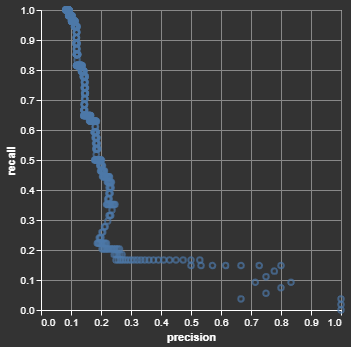

In [152]:
pr_curve( precision, recall, thresholds)

A threshold of -0.3072 is selected.

### Final model evaluation

In [154]:
def svc_by_proba( pipe_svc, X_test, threshold):
    proba = pipe_svc.decision_function( X_test)
    y_hat = proba > threshold
    return y_hat

In [158]:
pipe_svc_opt.fit( X_train, y_train)
y_hat_svc_opt = svc_by_proba( pipe_svc_opt, X_test, -0.3072)
better_confusion_matrix( y_test, y_hat_svc_opt, labels = [ True, False])

Predicted       
                  True  False
Actual True         98    986
       False        99  11932

In [157]:
print( classification_report( y_test, y_hat_svc_opt))

              precision    recall  f1-score   support

       False       0.92      0.99      0.96     12031
        True       0.50      0.09      0.15      1084

    accuracy                           0.92     13115
   macro avg       0.71      0.54      0.55     13115
weighted avg       0.89      0.92      0.89     13115



## Random Forest Classifier

### Model training

In [49]:
pipe_rfc = make_pipeline( column_transformer, RandomForestClassifier())
cv_result_rfc = cross_validate( pipe_rfc, X_train, y_train, cv = 5, return_train_score = True, scoring = 'precision')
pd.DataFrame( cv_result_rfc)

,fit_time,score_time,test_score,train_score
0,1.649736,0.053172,0.800000,1.0
1,1.647650,0.051142,0.428571,1.0
2,1.717302,0.068181,0.600000,1.0
3,1.810992,0.059877,0.333333,1.0
4,1.786026,0.099521,0.600000,1.0


In [50]:
pd.DataFrame( cv_result_rfc).mean()

fit_time       1.722341
score_time     0.066379
test_score     0.552381
train_score    1.000000
dtype: float64

### Hyperparameter optimization

### Final model evaluation

Best params are {'randomforestclassifier__n_estimators': 300,
 'randomforestclassifier__max_features': 'log2',
 'randomforestclassifier__max_depth': 90,
 'randomforestclassifier__criterion': 'log_loss',
 'randomforestclassifier__bootstrap': True}. No need to re-fit every time.

In [57]:
pipe_rfc_opt = make_pipeline( column_transformer,
                              RandomForestClassifier( n_estimators = 300,
                                                      max_features = 'log2',
                                                      max_depth = 90,
                                                      criterion = 'log_loss',
                                                      bootstrap = True))

pipe_rfc_opt.fit( X_train, y_train)
y_hat_rfc_opt = pipe_rfc_opt.predict( X_test)
better_confusion_matrix( y_test, y_hat_rfc_opt, labels = [ True, False])

Predicted       
                  True  False
Actual True         92    992
       False        53  11978

In [58]:
print( classification_report( y_test, y_hat_rfc_opt))

              precision    recall  f1-score   support

       False       0.92      1.00      0.96     12031
        True       0.63      0.08      0.15      1084

    accuracy                           0.92     13115
   macro avg       0.78      0.54      0.55     13115
weighted avg       0.90      0.92      0.89     13115



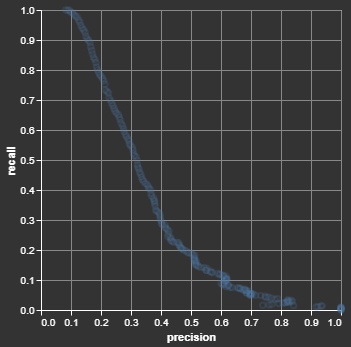

In [53]:
precision_rfc, recall_rfc, thresholds_rfc = precision_recall_curve( y_test, pipe_rfc_opt.predict_proba( X_test)[ :, 1])
pr_curve_rfc = pr_curve( precision_rfc, recall_rfc, thresholds_rfc)
pr_curve_rfc

## Gaussian Naive Bayes

### Model training

In [59]:
pipe_nb = make_pipeline( column_transformer, PowerTransformer(), GaussianNB())
cv_result_nb = cross_validate( pipe_nb, X_train, y_train, cv = 5, return_train_score = True, scoring = 'precision')
pd.DataFrame( cv_result_nb)

,fit_time,score_time,test_score,train_score
0,0.562566,0.022998,0.198895,0.214080
1,0.440101,0.021990,0.185185,0.216495
2,0.459871,0.023314,0.227848,0.207574
3,0.620473,0.028325,0.207792,0.210904
4,0.484377,0.035001,0.213115,0.204906


In [60]:
pd.DataFrame( cv_result_svc).mean()

fit_time       0.361034
score_time     0.155019
test_score     0.783333
train_score    0.973545
dtype: float64

### Final model evaluation

In [61]:
pipe_nb.fit( X_train, y_train)
y_hat_nb = pipe_nb.predict( X_test)
better_confusion_matrix( y_test, y_hat_nb, labels = [ True, False])

Predicted      
                  True False
Actual True        718   366
       False      2689  9342

In [62]:
print( classification_report( y_test, y_hat_nb))

              precision    recall  f1-score   support

       False       0.96      0.78      0.86     12031
        True       0.21      0.66      0.32      1084

    accuracy                           0.77     13115
   macro avg       0.59      0.72      0.59     13115
weighted avg       0.90      0.77      0.81     13115



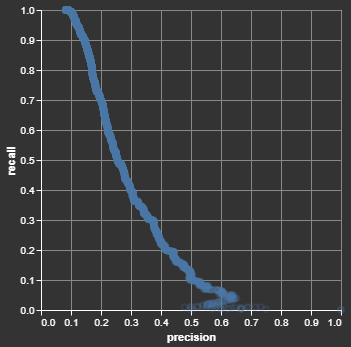

In [63]:
precision_nb, recall_nb, thresholds_nb = precision_recall_curve( y_test, pipe_nb.predict_proba( X_test)[ :, 1])
pr_curve_nb = pr_curve( precision_nb, recall_nb, thresholds_nb)
pr_curve_nb

## Logistic Regression

### Model training

In [64]:
pipe_logreg = make_pipeline( column_transformer, LogisticRegression( max_iter = 500, solver = 'saga'))
cv_result_logreg = cross_validate( pipe_logreg, X_train, y_train, cv = 5, return_train_score = True, scoring = 'precision')
pd.DataFrame( cv_result_logreg)

,fit_time,score_time,test_score,train_score
0,0.848457,0.016058,0.666667,0.567568
1,0.971491,0.019100,0.421053,0.616438
2,1.218420,0.014449,0.541667,0.578125
3,1.044688,0.014956,0.538462,0.579710
4,0.962475,0.014000,0.692308,0.582090


In [65]:
pd.DataFrame( cv_result_logreg).mean()

fit_time       1.009106
score_time     0.015713
test_score     0.572031
train_score    0.584786
dtype: float64

### Hyperparameter optimization

In [66]:
param_dist = {
    'logisticregression__C': [ 10**x for x in range( -2, 5)],
    'logisticregression__penalty': [ 'none', 'l2', 'l1', 'elasticnet'],
    'logisticregression__l1_ratio': [ 0, 0.5, 1]
}

grid_search_logreg = GridSearchCV(
    pipe_logreg, param_dist, cv = 5, scoring = 'precision', n_jobs=-1, return_train_score = True
)

grid_search_logreg.fit( X_train, y_train)
cv_results_logreg_opt = pd.DataFrame( grid_search_logreg.cv_results_)
cv_results_logreg_opt[ ['params', 'mean_test_score']].sort_values( 'mean_test_score', ascending = False).head()

C:\Users\User\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


,params,mean_test_score
3,"{'logisticregression__C': 0.01, 'logisticregre...",0.666667
5,"{'logisticregression__C': 0.01, 'logisticregre...",0.666667
1,"{'logisticregression__C': 0.01, 'logisticregre...",0.666667
9,"{'logisticregression__C': 0.01, 'logisticregre...",0.666667
23,"{'logisticregression__C': 0.1, 'logisticregres...",0.604664


In [67]:
grid_search_logreg.best_params_

{'logisticregression__C': 0.01,
 'logisticregression__l1_ratio': 0,
 'logisticregression__penalty': 'l2'}

### Final model evaluation

In [ ]:
pipe_logreg_opt = make_pipeline( column_transformer,
                                 LogisticRegression( max_iter = 500,
                                                     solver = 'saga',
                                                     C = grid_search_logreg[ 'logisticregression__C'],
                                                     penalty = grid_search_logreg[ 'logisticregression__penalty'],
                                                     l1_ratio = grid_search_logreg[ 'logisticregression__l1_ratio']))
pipe_logreg_opt.fit( X_train, y_train)
y_hat_logreg_opt = pipe_logreg_opt.predict( X_test)
better_confusion_matrix( y_test, y_hat_logreg, labels = [ True, False])

In [45]:
print( classification_report( y_test, y_hat_logreg_opt))

              precision    recall  f1-score   support

       False       0.92      1.00      0.96     12031
        True       0.47      0.04      0.07      1084

    accuracy                           0.92     13115
   macro avg       0.70      0.52      0.51     13115
weighted avg       0.88      0.92      0.88     13115

